In [31]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
import os

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def set_random_seed(seed):
    torch.manual_seed(seed)  # PyTorch

    # Ensures that PyTorch gets the same random numbers for CUDA as well, if using GPU.
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


def attention(P,Q,Z, activation = None):
    B= Z.shape[0]
    N = Z.shape[1]-1
    d = Z.shape[2]-1
    A = torch.eye(N+1).to(device)
    A[N,N] = 0
    Attn = torch.einsum('BNi, ij, BMj -> BNM', (Z,Q,Z))
    if activation is not None:
        Attn = activation(Attn)
    key = torch.einsum('ij, BNj -> BNi', (P,Z))
    Output = torch.einsum('BNM,ML, BLi -> BNi', (Attn,A,key))
    return Output /N


class Transformer_MLP(nn.Module):
    def __init__(self, n_layer, n_head, d, var, hidden_dim):
        super(Transformer_MLP, self).__init__()
        self.register_parameter('allparam', torch.nn.Parameter(torch.zeros(n_layer, n_head, 2, d+1, d+1)))
        with torch.no_grad():
            self.allparam.normal_(0,var)
        self.n_layer = n_layer
        self.n_head = n_head
        self.mlp = nn.Sequential(nn.Linear(d, hidden_dim),nn.ReLU(),nn.Linear(hidden_dim, d))

    def forward(self, Z):
        Z[:,:,:-1] = self.mlp(Z[:,:,:-1].clone())
        for i in range(self.n_layer):
            Zi = Z
            residues = 0
            # the forwarad map of each layer is given by F(Z) = Z + attention(Z)
            for j in range(self.n_head):
                Pij = self.allparam[i,j,0,:,:]
                Qij = self.allparam[i,j,1,:,:]
                residues = residues + attention(Pij,Qij,Zi)
            Z = Zi + residues
        return Z

# evaluate the loss of model, given data (Z,y)
def in_context_loss(model, Z, y):
    N = Z.shape[1]-1
    d = Z.shape[2]-1
    output = model(Z)
    diff = output[:,N,d]+y
    loss = ((diff)**2).mean()
    return loss

def generate_data_mlp(N, B, d, randomMLP):
    # Generate random input data
    X = torch.FloatTensor(B, N, d).normal_(0, 1).to(device)
    X_test = torch.FloatTensor(B, 1, d).normal_(0, 1).to(device)

    # Additional transformations if mode is 'sphere' or 'gamma' [Similar to the existing generate_data function]

    X_MLP = randomMLP(X.view(-1, d)).view(B, N, d)
    X_test_MLP = randomMLP(X_test.view(-1, d)).view(B, 1, d)

    W = torch.FloatTensor(B, d).normal_(0,1).cuda()
    y = torch.einsum('bi,bni->bn', (W, X_MLP)).unsqueeze(2)
    y_zero = torch.zeros(B,1,1).cuda()
    y_test = torch.einsum('bi,bni->bn', (W, X_test_MLP)).squeeze(1)
    X_comb= torch.cat([X,X_test],dim=1)
    y_comb= torch.cat([y,y_zero],dim=1)
    Z= torch.cat([X_comb,y_comb],dim=2)

    return Z, y_test
# Setup
N=20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_layer = 3  # number of layers of transformer
d = 5        # dimension for the data
n_head = 1   # 1-headed attention
B = 2000     # minibatch size for sine data
var = 0.1 # 0.0001 # initializations scale of transformer parameter
clip = 1


tuning_epochs = 400
max_iters = 10000  # Number of Iterations to run
hidden_dim = 10
learning_rates = [0.001, 0.01, 0.05, 0.1]

np.random.seed(7)
torch.manual_seed(7)

randomMLP = nn.Sequential(nn.Linear(d, hidden_dim),nn.ReLU(),nn.Linear(hidden_dim, d)).to(device)

for para in randomMLP.parameters():
    para.requires_grad = False
    
# Function to run training
def train_transformer(optimizer_name, learning_rate, max_epochs, seed, randomMLP):
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Instantiate model
    model = Transformer_MLP(n_layer, n_head, d, var, 3* hidden_dim).to(device)

    # Wrap the model for DataParallel
    # if torch.cuda.device_count() > 1:
    #     print(f"Let's use {torch.cuda.device_count()} GPUs!")
    #     model = nn.DataParallel(model)

    if optimizer_name == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif optimizer_name == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.9))

    # pipe output to log file
    log_dir = 'log_nonlinear' 
    os.makedirs(log_dir, exist_ok=True)
    filename = log_dir + f'/nonlinear_layer{n_layer}_N{N}_{optimizer_name}_lr{learning_rate}_sd{seed}.pth'

    losses = []
    hist_list = list()
    param_list = list()
    for epoch in range(max_epochs):
        # Generate data
        Z, y = generate_data_mlp(N=N, B=B, d=d, randomMLP=randomMLP)

        # Move data to the correct device
        Z, y = Z.to(device), y.to(device)

        # Training step
        optimizer.zero_grad()
        loss = in_context_loss(model, Z, y)
        loss.backward()
        grads = []
        for param in model.parameters():
            grads.append(param.grad.clone().view(-1))
        gradient = torch.cat(grads)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

        optimizer.step()

        optimizer.zero_grad()

        # Record loss
        losses.append(loss.item())
        
        with torch.no_grad():
            params = []
            for param in model.parameters():
                params.append(param.data.clone().view(-1))
            params_vec = torch.cat(params)
            param_list.append(params_vec)
            hist_list.append(model.state_dict())

        # Optionally print progress
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()} GramNorm: {torch.norm(gradient).item()} WeightNorm: {torch.norm(params_vec).item()}')

    torch.save({'hist_list':hist_list, 'param_list':param_list}, filename)
    return losses

# Tuning learning rate

optimal_lr = {"adam":0.01, "sgd":0.05}
# for optimizer_name in ['adam','sgd']:
#     best_lr = None
#     best_loss = float('inf')
#     for lr in learning_rates:
#         print(f"Training with {optimizer_name} optimizer, Learning Rate: {lr}")
#         losses = train_transformer(optimizer_name, lr, tuning_epochs)
#         avg_loss = np.mean(losses[-20:])  # Average loss over last epochs
#         if avg_loss < best_loss:
#             best_loss = avg_loss
#             best_lr = lr
#     optimal_lr[optimizer_name] = best_lr
#     print(f"Optimal Learning Rate for {optimizer_name}: {best_lr}")

num_runs = 5
final_losses = {}

In [32]:
for optimizer_name, lr in optimal_lr.items():
    print(f"Extended Training with {optimizer_name} optimizer, Learning Rate: {lr}")
    all_losses = []
    for seed in range(num_runs):
        set_random_seed(seed)  # Function to set the random seed, define it as needed
        losses = train_transformer(optimizer_name, lr, max_iters, seed, randomMLP)
        all_losses.append(losses)

    # Calculate the mean and standard deviation of the losses
    mean_losses = np.mean(all_losses, axis=0)
    std_losses = np.std(all_losses, axis=0)
    final_losses[optimizer_name] = (mean_losses, std_losses, all_losses)

Extended Training with adam optimizer, Learning Rate: 0.01
Epoch 0, Loss: 0.2614056468009949 GramNorm: 0.03526539355516434 WeightNorm: 3.9986960887908936
Epoch 100, Loss: 0.06507513672113419 GramNorm: 0.08080150932073593 WeightNorm: 4.7884840965271
Epoch 200, Loss: 0.03773293271660805 GramNorm: 0.03286851570010185 WeightNorm: 5.327773094177246
Epoch 300, Loss: 0.01713530533015728 GramNorm: 0.026472071185708046 WeightNorm: 5.9592108726501465
Epoch 400, Loss: 0.014501622878015041 GramNorm: 0.02285051718354225 WeightNorm: 6.324523448944092
Epoch 500, Loss: 0.015883669257164 GramNorm: 0.05616968870162964 WeightNorm: 6.49383544921875
Epoch 600, Loss: 0.010112064890563488 GramNorm: 0.02493205852806568 WeightNorm: 6.943401336669922
Epoch 700, Loss: 0.007138738874346018 GramNorm: 0.010263846255838871 WeightNorm: 7.505331993103027
Epoch 800, Loss: 0.008114227093756199 GramNorm: 0.02292889915406704 WeightNorm: 7.748950958251953
Epoch 900, Loss: 0.0017777447355911136 GramNorm: 0.01744747906923294

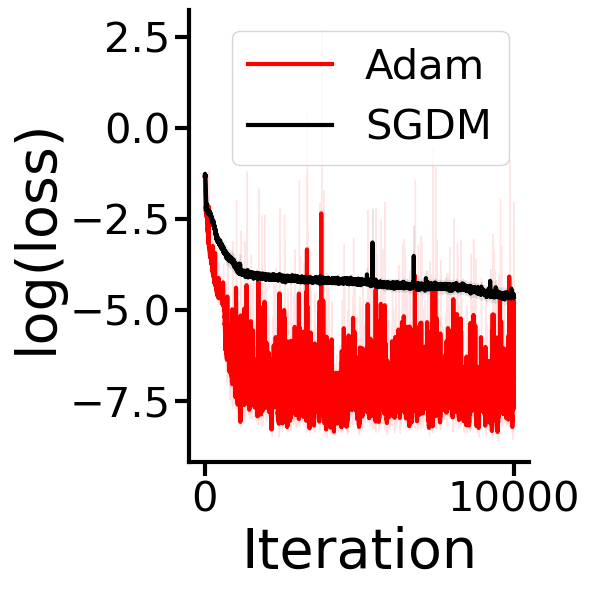

In [33]:
fig_dir = 'figures_nonlinear' 
os.makedirs(fig_dir, exist_ok=True)

fig, ax = plt.subplots(1, 1,figsize = (6, 6))
epochs = range(len(mean_losses))  # Assuming all runs have the same number of epochs
for optimizer_name, (mean_losses, std_losses, all_losses) in final_losses.items():
    mean_losses = np.mean(np.log(all_losses), axis=0)
    std_losses = np.std(np.log(all_losses), axis=0)
    if optimizer_name == 'sgd':
        ax.plot(epochs, mean_losses, color = 'black', lw=3, label='SGDM')
        ax.fill_between(epochs, mean_losses - std_losses/2, mean_losses + std_losses/2, color='black', alpha=0.1)
    if optimizer_name == 'adam':
        ax.plot(epochs, mean_losses, color = 'red', lw=3, label='Adam')
        ax.fill_between(epochs, mean_losses - std_losses/2, mean_losses + std_losses/2, color='red', alpha=0.1)
    ax.set_xlabel('Iteration',fontsize=40)
    ax.set_ylabel('log(loss)',fontsize=40)
    ax.tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10)
    ax.tick_params(axis='both', which='minor', labelsize=20, width = 3, length = 5)
    ax.legend(fontsize=30)
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    # ax.set_yscale('log')
    
    plt.tight_layout()
    plt.savefig(fig_dir + '/loss_layer{}_N{}.pdf'.format(n_layer, N), dpi=600)

In [34]:
log_dir = 'log_nonlinear' 
seed = 7
np.random.seed(seed)
torch.manual_seed(seed)

model = Transformer_MLP(n_layer, n_head, d, var, 3* hidden_dim)
model.to(device)

# compute estimated true gradient using large batch
B_large = B*100
Z, y = generate_data_mlp(N=N, B=B_large, d=d, randomMLP=randomMLP)
Z = Z.cuda()
y = y.cuda()

loss = in_context_loss(model, Z, y)
loss.backward()

grads = []
for param in model.parameters():
    grads.append(param.grad.clone().view(-1))
    param.grad.zero_()
gradient = torch.cat(grads)

noiseList = []
n_sample = 100000
for _ in range(n_sample):
    # compute stochastic gradient
    Z, y = generate_data_mlp(N=N, B=B, d=d, randomMLP=randomMLP)
    Z = Z.cuda()
    y = y.cuda()
    
    loss = in_context_loss(model, Z, y)
    loss.backward()

    stochastic_grads = []
    for param in model.parameters():
        stochastic_grads.append(param.grad.clone().view(-1))
        param.grad.zero_()
    stochastic_gradient = torch.cat(stochastic_grads)

    noise = torch.norm(stochastic_gradient - gradient)
    noiseList.append(noise.item())

filename = log_dir + '/stochastic_gradient_noise_layer{}_N{}.pth'.format(n_layer,N)
torch.save({'noiseList':noiseList}, filename)


loaded_dict = torch.load(filename)
noiseList = loaded_dict['noiseList']
noiseArray = np.array(noiseList)

/tmp/ipykernel_1472946/4210184796.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


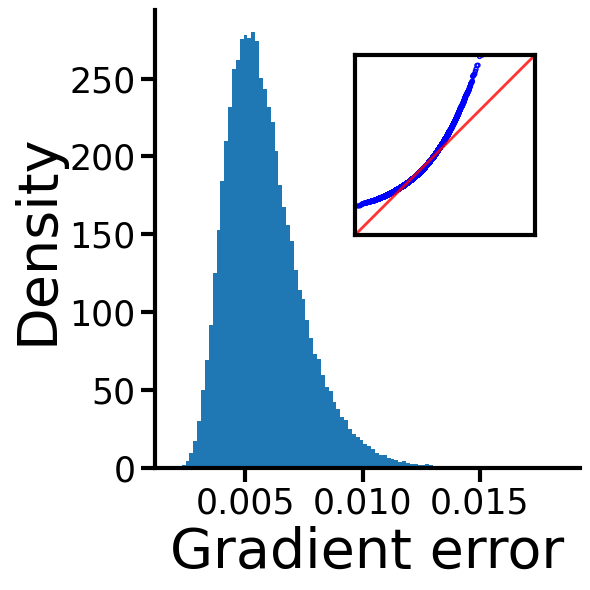

In [35]:
import scipy.stats as stats

fig, ax = plt.subplots(1, 1,figsize = (6, 6))
ax.hist(noiseList, bins=100, density=True, alpha=1.0, edgecolor = 'black', linewidth = 0.001)
ax.tick_params(axis='both', which='major', labelsize=25, width = 3, length = 10)
ax.tick_params(axis='both', which='minor', labelsize=25, width = 3, length = 5)

ax.spines[['right', 'top']].set_visible(False)
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.set_ylabel('Density',fontsize=40)
ax.set_xlabel('Gradient error',fontsize=40)

ax_box = plt.axes([0.6, 0.6, 0.3, 0.3])
(osm, osr), (slope, intercept, r) = stats.probplot(noiseList, dist=stats.norm, plot=None)
min_x = osm[0]
max_x = (osr[-1] - intercept) / slope
x = np.linspace(min_x, max_x, 100)
ax_box.plot(x, slope*x + intercept, color='r', alpha=.8, linewidth=2)
ax_box.scatter(osm, osr, s=8, alpha=1, facecolors='none', edgecolors='b')

ax_box.set_xlim([min_x, max_x])
ax_box.set_ylim([slope*min_x + intercept, slope*max_x + intercept])
ax_box.get_xaxis().set_visible(False)
ax_box.get_yaxis().set_visible(False)
ax_box.spines[['left', 'right', 'top', 'bottom']].set_linewidth(3)

plt.tight_layout()
plt.savefig(fig_dir + '/heavy_tail_noise_layer{}_N{}_qq.jpg'.format(n_layer, N), dpi=300, bbox_inches="tight")

In [38]:
log_dir = 'log_nonlinear'
condnum_plots = {}
stride = 250
max_iters = 10000
num_runs = 5

for optimizer_name, lr in optimal_lr.items():
    for seed in range(num_runs):
        np.random.seed(seed)
        torch.manual_seed(seed)
        Z, y = generate_data_mlp(N=N, B=B, d=d, randomMLP=randomMLP)
        Z = Z.to(device)
        y = y.to(device)

        def eval_loss_hess(params_vec):
            global n_layer, n_head, d, var, hidden_dim
            model = Transformer_MLP(n_layer, n_head, d, var, 3*hidden_dim).to(device)
            idx = 0
            for name, param in model.named_parameters():
                l = len(param.data.flatten())
                if name == 'allparam':
                    allparam = params_vec[idx:idx+l].reshape(param.data.shape)
                elif name == "mlp.0.weight":
                    mlp0_weight = params_vec[idx:idx+l].reshape(param.data.shape)
                elif name == "mlp.0.bias":
                    mlp0_bias = params_vec[idx:idx+l].reshape(param.data.shape)
                elif name == "mlp.2.weight":
                    mlp2_weight = params_vec[idx:idx+l].reshape(param.data.shape)
                elif name == "mlp.2.bias":
                    mlp2_bias = params_vec[idx:idx+l].reshape(param.data.shape)
                idx = idx + l

            output = Z.clone()
            output_mlp = Z[:,:,:-1].clone()
            output_mlp = torch.einsum('hd,bnd->bnh', (mlp0_weight, output_mlp))
            output_mlp = output_mlp + mlp0_bias
            output_mlp = nn.functional.relu(output_mlp)
            output_mlp = torch.einsum('dh,bnh->bnd', (mlp2_weight, output_mlp))
            output_mlp = output_mlp + mlp2_bias
            output[:,:,:-1] = output_mlp
            for i in range(n_layer):
                Zi = output
                residues = 0
                # the forwarad map of each layer is given by F(Z) = Z + attention(Z)
                for j in range(n_head):
                    Pij = allparam[i,j,0,:,:]
                    Qij = allparam[i,j,1,:,:]
                    residues = residues + attention(Pij,Qij,Zi)
                output = Zi + residues
            diff = output[:,N,d]+y
            loss = ((diff)**2).mean() 
            return loss

        filename = log_dir + f'/nonlinear_layer{n_layer}_N{N}_{optimizer_name}_lr{lr}_sd{seed}.pth'
        loaded_dict = torch.load(filename)
        param_list = loaded_dict['param_list']

        condnums = torch.zeros(max_iters//stride)

        for t in range(0, max_iters, stride):
            params_vec = param_list[t]
            hess = torch.autograd.functional.hessian(eval_loss_hess, params_vec)

            diag_hess = torch.abs(torch.diag(hess, 0))
            condnum = torch.max(diag_hess) / torch.median(diag_hess)
            condnums[t//stride] = condnum.item()
        condnum_plots[(optimizer_name, lr, seed)] = condnums

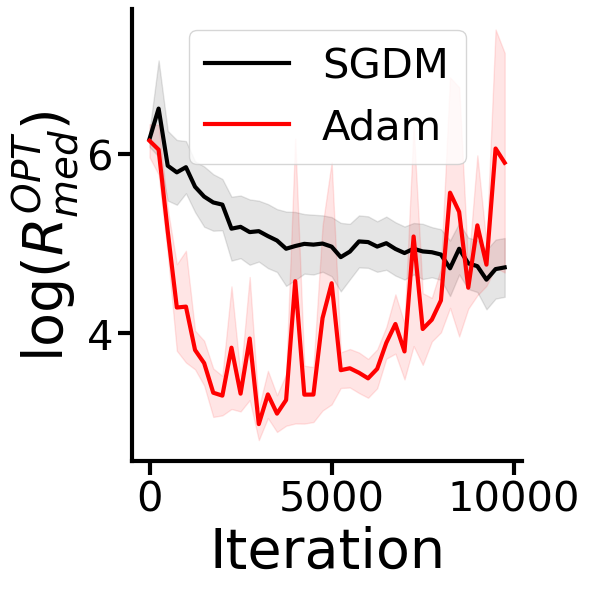

In [43]:
fig_dir = 'figures_nonlinear' 
os.makedirs(fig_dir, exist_ok=True)

seeds = [0,1,2,3,4]
max_iters = 10000

fig, ax = plt.subplots(1, 1,figsize = (6, 6))

for (alg, lr) in [('sgd', 0.05),('adam', 0.01)]:
    condnums = torch.zeros(len(seeds), max_iters//stride)
    for idx, sd in enumerate(seeds):
        condnums[idx,:] = condnum_plots[(alg, lr, sd)]
    condnums_mean = torch.mean(np.log(condnums), axis=0)
    condnums_std = torch.std(np.log(condnums), axis=0)
    if alg == 'sgd':
        ax.plot(range(0,max_iters,stride), condnums_mean, color = 'black', lw = 3, label='SGDM')
        ax.fill_between(range(0,max_iters,stride), condnums_mean-condnums_std/2, condnums_mean+condnums_std/2, color = 'black', alpha = 0.1)
    elif alg == 'adam':
        ax.plot(range(0,max_iters,stride), condnums_mean, color = 'red', lw = 3, label='Adam')
        ax.fill_between(range(0,max_iters,stride), condnums_mean-condnums_std/2, condnums_mean+condnums_std/2, color = 'red', alpha = 0.1)

    ax.set_xlabel('Iteration',fontsize=40)
    ax.set_ylabel(r'$\log(R_{med}^{OPT})$',fontsize=40)

    ax.tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10)
    ax.tick_params(axis='both', which='minor', labelsize=20, width = 3, length = 5)
    ax.legend(fontsize=30)
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    # ax.set_yscale('log')
    
    plt.tight_layout()
    plt.savefig(fig_dir + '/condition_number_layer{}_N{}.pdf'.format(n_layer, N), dpi=600)

In [40]:
print('Condion number SGDM/Adam')
for t in [0, 750, 1250]:
    ratios = torch.zeros(len(seeds))
    for idx, sd in enumerate(seeds):
        ratios[idx] = condnum_plots[('sgd', 0.05, sd)][t//stride] / condnum_plots[('adam', 0.01, sd)][t//stride]
    ratios_mean = torch.mean(ratios).item()
    ratios_std = torch.std(ratios).item()

    print('Iteration {} | Mean: {}  Std: {}'.format(t, ratios_mean, ratios_std))

Condion number SGDM/Adam
Iteration 0 | Mean: 1.0714421272277832  Std: 0.40197867155075073
Iteration 750 | Mean: 5.40762996673584  Std: 3.960836172103882
Iteration 1250 | Mean: 6.6050519943237305  Std: 2.543187141418457


In [41]:
dir_smoothness_plots = {}
stride = 250
max_iters = 10000
num_runs = 5

for optimizer_name, lr in optimal_lr.items():
    for seed in range(num_runs):
        np.random.seed(seed)
        torch.manual_seed(seed)
        randomMLP = nn.Sequential(nn.Linear(d, hidden_dim),nn.ReLU(),nn.Linear(hidden_dim, d)).to(device)
        Z, y = generate_data_mlp(N=N, B=B, d=d, randomMLP=randomMLP)
        Z = Z.to(device)
        y = y.to(device)

        filename = log_dir + f'/nonlinear_layer{n_layer}_N{N}_{optimizer_name}_lr{lr}_sd{seed}.pth'
        loaded_dict = torch.load(filename)
        param_list = loaded_dict['param_list']

        dir_smoothnesses = torch.zeros((max_iters)//stride)
        for t in range(0,max_iters-1,stride):
            params_vec = param_list[t]
            params_vec_next = param_list[t+1]

            dp = params_vec_next - params_vec
            dp = dp / dp.norm()

            s = torch.zeros(1, device=device)
            def eval_dir_loss_hess(t):
                global n_layer, n_head, d, var, hidden_dim

                params_vec_t = params_vec +  t*dp
                model = Transformer_MLP(n_layer, n_head, d, var, 3*hidden_dim).to(device)
                idx = 0
                for name, param in model.named_parameters():
                    l = len(param.data.flatten())
                    if name == 'allparam':
                        allparam = params_vec_t[idx:idx+l].reshape(param.data.shape)
                    elif name == "mlp.0.weight":
                        mlp0_weight = params_vec_t[idx:idx+l].reshape(param.data.shape)
                    elif name == "mlp.0.bias":
                        mlp0_bias = params_vec_t[idx:idx+l].reshape(param.data.shape)
                    elif name == "mlp.2.weight":
                        mlp2_weight = params_vec_t[idx:idx+l].reshape(param.data.shape)
                    elif name == "mlp.2.bias":
                        mlp2_bias = params_vec_t[idx:idx+l].reshape(param.data.shape)
                    idx = idx + l

                output = Z.clone()
                output_mlp = Z[:,:,:-1].clone()
                output_mlp = torch.einsum('hd,bnd->bnh', (mlp0_weight, output_mlp))
                output_mlp = output_mlp + mlp0_bias
                output_mlp = nn.functional.relu(output_mlp)
                output_mlp = torch.einsum('dh,bnh->bnd', (mlp2_weight, output_mlp))
                output_mlp = output_mlp + mlp2_bias
                output[:,:,:-1] = output_mlp
                for i in range(n_layer):
                    Zi = output
                    residues = 0
                    # the forwarad map of each layer is given by F(Z) = Z + attention(Z)
                    for j in range(n_head):
                        Pij = allparam[i,j,0,:,:]
                        Qij = allparam[i,j,1,:,:]
                        residues = residues + attention(Pij,Qij,Zi)
                    output = Zi + residues
                diff = output[:,N,d]+y
                loss = ((diff)**2).mean() 
                return loss
            
            dir_smoothness = torch.autograd.functional.hessian(eval_dir_loss_hess, tuple(s))
            dir_smoothnesses[t//stride] = dir_smoothness[0][0].item()
        dir_smoothness_plots[(optimizer_name, lr, seed)] = dir_smoothnesses

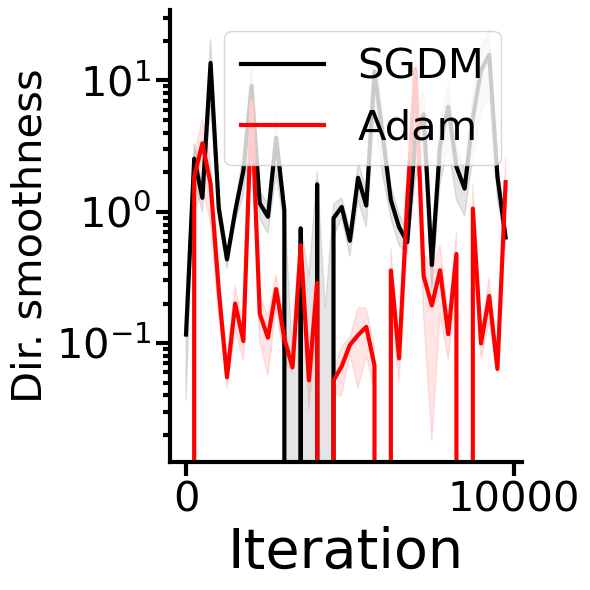

In [49]:
fig_dir = 'figures_nonlinear' 
os.makedirs(fig_dir, exist_ok=True)

seeds = [0,1,2,3,4]

fig, ax = plt.subplots(1, 1,figsize = (6, 6))

for (alg, lr) in [('sgd', 0.05),('adam', 0.01)]:
    dir_smoothnesses = torch.zeros(len(seeds), max_iters//stride)
    for idx, sd in enumerate(seeds):
        dir_smoothnesses[idx] = dir_smoothness_plots[(alg, lr, sd)]
    dir_smoothnesses_mean = torch.mean(dir_smoothnesses, axis=0)
    dir_smoothnesses_std = torch.std(dir_smoothnesses, axis=0)
    if alg == 'sgd':
        ax.plot(range(0,max_iters,stride), dir_smoothnesses_mean, color = 'black', lw = 3,label='SGDM')
        ax.fill_between(range(0,max_iters,stride), dir_smoothnesses_mean-dir_smoothnesses_std/4, dir_smoothnesses_mean+dir_smoothnesses_std/4, color = 'black', alpha = 0.1)
    elif alg == 'adam':
        ax.plot(range(0,max_iters,stride), dir_smoothnesses_mean, color = 'red', lw = 3, label='Adam')
        ax.fill_between(range(0,max_iters,stride), dir_smoothnesses_mean-dir_smoothnesses_std/4, dir_smoothnesses_mean+dir_smoothnesses_std/4, color = 'red', alpha = 0.1)

    ax.set_xlabel('Iteration',fontsize=40)
    ax.set_ylabel('Dir. smoothness',fontsize=30)

    ax.tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10)
    ax.tick_params(axis='both', which='minor', labelsize=20, width = 3, length = 5)
    ax.legend(fontsize=30)
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.set_yscale('log')
    
    plt.tight_layout()
    plt.savefig(fig_dir + '/dir_smoothnesses_layer{}_N{}.pdf'.format(n_layer, N), dpi=600)